# Overview

Before building the base GRN, we need to annotate the coaccessible peaks and filter our active promoter/enhancer elements. First, we will identify the peaks around transcription starting sites (TSS). We will then merge the Cicero data with the TSS peak information and filter any peaks with weak connections to the TSS peaks. As such, the filtered peak data will only include TSS peaks and peaks with strong TSS connections. These will be our active promoter/enhancer elements for our base GRN. 

### Notebook file

Notebook file is available on CellOracle GitHub page.
https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/01_ATAC-seq_data_processing/option1_scATAC-seq_data_analysis_with_cicero/02_preprocess_peak_data.ipynb



### NOTES:
- 1) the "peaks" and "cicero_connections" have "peaks" as "chromosomeNumber-start-end". CellOracle peaks have the foramt of "chrNum_start_end" (i.e. "chr1_12345-34567"), so we need to edit the string.

# 0. Import libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm


In [15]:
from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

'0.14.0'

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# 1. Load scATAC peak data and peak connection data made with Cicero

## 1.0. Download data

In this notebook, we will annotate and filter output from Cicero. Please refer to the previous step to learn about data preparation with Cicero.
https://morris-lab.github.io/CellOracle.documentation/tutorials/base_grn.html#step1-scatac-seq-analysis-with-cicero


Here, we will use the preprocessed fetal brain scATAC-seq data from step 1.


You can download the demo file by running the following command. 

Note: If the download fails, please manually download and unzip the data.
https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/all_peaks.csv

https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/cicero_connections.csv

In [4]:
# # Download file. 
# !wget https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/all_peaks.csv
# !wget https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/cicero_connections.csv
    
# # If you are using macOS, please try the following command.
# #!curl -O https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/all_peaks.csv
# #!curl -O https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/cicero_connections.csv


--2023-01-20 17:19:21--  https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/all_peaks.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2940392 (2.8M) [text/plain]
Saving to: ‘all_peaks.csv’

all_peaks.csv       100%[===================>]   2.80M  --.-KB/s    in 0.03s   

2023-01-20 17:19:22 (92.3 MB/s) - ‘all_peaks.csv’ saved [2940392/2940392]

--2023-01-20 17:19:22--  https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/cicero_connections.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 

## 1.1. Load data

In [4]:
cicero_output_path = "/home/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/"

In [5]:
# Load scATAC-seq peak list.
peaks = pd.read_csv(cicero_output_path+"TDR118_CRG_arc_peaks.csv", index_col=0)
peaks = peaks.x.values
peaks

array(['1-2372-3057', '1-6507-7253', '1-11485-12198', ...,
       '9-56450898-56451686', '9-56452315-56452858',
       '9-56459068-56459827'], dtype=object)

In [6]:
# add "chr" in front of each peak element for formatting (CellOracle genome reference)
peaks = "chr" + peaks
peaks

# reformat the peaks (replace the "-" with "_")
peaks = [s.replace("-","_") for s in peaks]
peaks = np.array(peaks)
peaks

array(['chr1_2372_3057', 'chr1_6507_7253', 'chr1_11485_12198', ...,
       'chr9_56450898_56451686', 'chr9_56452315_56452858',
       'chr9_56459068_56459827'], dtype='<U23')

In [7]:
# Load Cicero coaccessibility scores.
cicero_connections = pd.read_csv(cicero_output_path + "TDR118_cicero_connections_CRG_arc_peaks.csv", index_col=0)
cicero_connections.head()

,Peak1,Peak2,coaccess
1,1-10000089-10000951,1-9799170-9799935,-0.073049
2,1-10000089-10000951,1-9820778-9821643,-0.069486
3,1-10000089-10000951,1-9846358-9847274,-0.040536
4,1-10000089-10000951,1-9858069-9858966,-0.028729
5,1-10000089-10000951,1-9859992-9860913,-0.025691


In [8]:
# add "chr" in front of each peak element for formatting (CellOracle genome reference)
cicero_connections["Peak1"] = "chr" + cicero_connections["Peak1"]
cicero_connections["Peak2"] = "chr" + cicero_connections["Peak2"]

# replace the "-" with "_"
cicero_connections["Peak1"] = [s.replace("-","_") for s in cicero_connections["Peak1"]]
cicero_connections["Peak2"] = [s.replace("-","_") for s in cicero_connections["Peak2"]]

cicero_connections.head()

,Peak1,Peak2,coaccess
1,chr1_10000089_10000951,chr1_9799170_9799935,-0.073049
2,chr1_10000089_10000951,chr1_9820778_9821643,-0.069486
3,chr1_10000089_10000951,chr1_9846358_9847274,-0.040536
4,chr1_10000089_10000951,chr1_9858069_9858966,-0.028729
5,chr1_10000089_10000951,chr1_9859992_9860913,-0.025691


<AxesSubplot: >

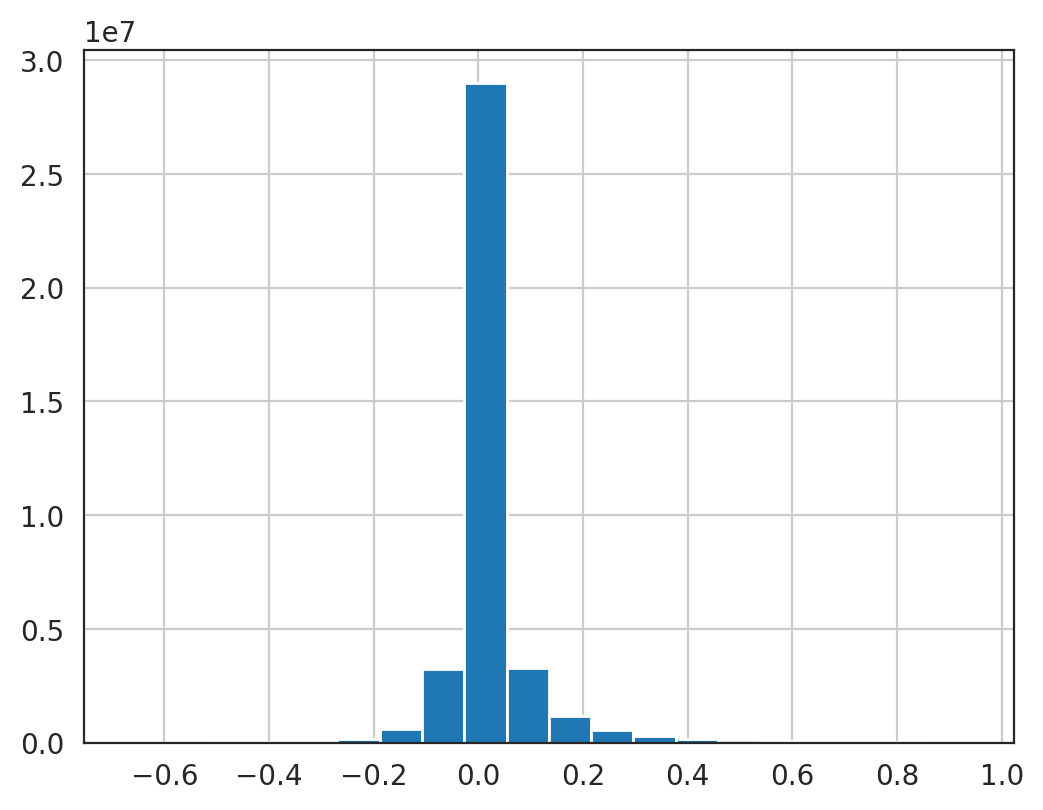

In [30]:
cicero_connections["coaccess"].hist(bins=20)

In [13]:
len(cicero_connections)

39776378

In [43]:
cicero_connections[cicero_connections["coaccess"]>0.8]

,Peak1,Peak2,coaccess
2869,chr1-10097950-10098854,chr1-10100909-10101818,0.834009
2988,chr1-10100909-10101818,chr1-10097950-10098854,0.834009
5946,chr1-102200-103114,chr1-70843-71645,0.881760
5947,chr1-102200-103114,chr1-71970-72843,0.863096
5955,chr1-102200-103114,chr1-90312-91095,0.810196
...,...,...,...
39931079,chr9-7593119-7594042,chr9-7589909-7590794,0.877671
39941915,chr9-7790973-7791875,chr9-8110320-8111188,0.846106
39955977,chr9-8110320-8111188,chr9-7790973-7791875,0.846106
39974232,chr9-8697384-8698430,chr9-8714275-8715094,0.805614


# 2. Annotate transcription start sites (TSSs)¶
## IMPORTANT: Please make sure that you are setting correct reference genoms.
 If your scATAC-seq data was generated with mm10 reference genome, please set `ref_genome="mm10"`.
 
You can check supported reference genome using `ma.SUPPORTED_REF_GENOME`

 If your reference genome is not in the list, please send a request to us through CellOracle GitHub issue page.
 
 - We will use the danRer11 (GRCz11)

In [9]:
ma.SUPPORTED_REF_GENOME

,species,ref_genome,provider
0,Human,hg38,UCSC
1,Human,hg19,UCSC
2,Mouse,mm39,UCSC
3,Mouse,mm10,UCSC
4,Mouse,mm9,UCSC
5,S.cerevisiae,sacCer2,UCSC
6,S.cerevisiae,sacCer3,UCSC
7,Zebrafish,danRer7,UCSC
8,Zebrafish,danRer10,UCSC
9,Zebrafish,danRer11,UCSC


In [21]:
from pybedtools import BedTool

In [22]:
import pybedtools

In [20]:
BedTool.intersect

<function pybedtools.bedtool.BedTool._log_to_history.<locals>.decorated(self, *args, **kwargs)>

In [16]:
##!! Please make sure to specify the correct reference genome here
tss_annotated = ma.get_tss_info(peak_str_list=peaks, ref_genome="danRer11") 

# Check results
tss_annotated.tail()

NotImplementedError: "intersectBed" does not appear to be installed or on the path, so this method is disabled.  Please install a more recent version of BEDTools and re-import to use this method.

In [13]:
help(ma.get_tss_info)

Help on function get_tss_info in module celloracle.motif_analysis.tss_annotation:

get_tss_info(peak_str_list, ref_genome, verbose=True, custom_tss_file_path=None)
    Get annotation about Transcription Starting Site (TSS).
    
    Args:
        peak_str_list (list of str): list of peak_id. e.g., [“chr5_0930303_9499409”, “chr11_123445555_123445577”]
        ref_genome (str): reference genome name.
        verbose (bool): verbosity.
        custom_tss_file_path (str): File path to the custom TSS reference bed file. If you just want to use reference genome that are supported in the CellOracle, you don't need to set this parameter.



# 3. Integrate TSS info and cicero connections

The output file after the integration process has three columns: `["peak_id", "gene_short_name", "coaccess"`].

- "peak_id" is either the TSS peak or the peaks that have a connection to a TSS peak.
- "gene_short_name" is the gene name that associated with the TSS site. 
- "coaccess" is the coaccessibility score between the peak and a TSS peak. If the score is 1, it means that the peak is a TSS itself.

In [9]:
integrated = ma.integrate_tss_peak_with_cicero(tss_peak=tss_annotated, 
                                               cicero_connections=cicero_connections)
print(integrated.shape)
integrated.head()

(44309, 3)


,peak_id,gene_short_name,coaccess
0,chr10_100006139_100006389,Tmtc3,0.017915
1,chr10_100015291_100017830,Kitl,1.000000
2,chr10_100018677_100020384,Kitl,0.146517
3,chr10_100050858_100051762,Kitl,0.069751
4,chr10_100052829_100053395,Kitl,0.202670


# 4. Filter peaks
Remove peaks with weak coaccessibility scores.

In [10]:
peak = integrated[integrated.coaccess >= 0.8]
peak = peak[["peak_id", "gene_short_name"]].reset_index(drop=True)

In [11]:
print(peak.shape)
peak.head()

(15779, 2)


,peak_id,gene_short_name
0,chr10_100015291_100017830,Kitl
1,chr10_100486534_100488209,Tmtc3
2,chr10_100588641_100589556,4930430F08Rik
3,chr10_100741247_100742505,Gm35722
4,chr10_101681379_101682124,Mgat4c


# 5. Save data
Save the promoter/enhancer peaks.

In [12]:
peak.to_csv("processed_peak_file.csv")

**Please go to next step: Transcriptoin factor motif scan**

https://morris-lab.github.io/CellOracle.documentation/tutorials/motifscan.html